In [19]:
from excel_time_series_provider import ExcelTimeSeriesProvider
from matplotlib import pyplot
import pandas as pd
import numpy as np

from utils import *

In [20]:
##Parameters
stock_name = "NESTE FH Equity"
index_name = "SXXP Index"
filename = "Neste and SXXP price.xlsx"
price_type = "PX_LAST"

In [21]:
##parse time series and create resulting dataframe
ts_provider = ExcelTimeSeriesProvider(filename)
##get_time_series method designed in a polymorphic way to allow passing any number of parameters
##you don't need to specify the position of the time series in the excel workbook, just the labels characterising it 
NESTE_ts = ts_provider.get_time_series(stock_name, price_type)
SXXP_ts = ts_provider.get_time_series(index_name, price_type)
dates = ts_provider.get_time_series("Dates")
ts_df = pd.DataFrame(list(zip(dates, NESTE_ts, SXXP_ts)),
               columns =['Dates', stock_name, index_name], index=dates)
ts_df.head()

,Dates,NESTE FH Equity,SXXP Index
2012-11-14,2012-11-14,2.3137,268.14
2012-11-15,2012-11-15,2.3036,265.52
2012-11-16,2012-11-16,2.2433,262.86
2012-11-19,2012-11-19,2.3954,268.58
2012-11-20,2012-11-20,2.3954,269.49


In [22]:
## Add resulting relative performance to dataframe
ts_df['daily_relative_performance'] = ts_df[stock_name] / ts_df[index_name]
ts_df.head()

,Dates,NESTE FH Equity,SXXP Index,daily_relative_performance
2012-11-14,2012-11-14,2.3137,268.14,0.008629
2012-11-15,2012-11-15,2.3036,265.52,0.008676
2012-11-16,2012-11-16,2.2433,262.86,0.008534
2012-11-19,2012-11-19,2.3954,268.58,0.008919
2012-11-20,2012-11-20,2.3954,269.49,0.008889


In [23]:
## Compute 3M rolling max and add it to dataframe
## If the start day of the rolling period falls on a weekend, we take the following week day
ts_df['3M rolling max'] = [
    ts_df.loc[
        edt - pd.tseries.offsets.DateOffset(months=3):edt, 'daily_relative_performance'
    ].max() if (edt - pd.tseries.offsets.DateOffset(months=3) >= ts_df['Dates'].iloc[0]) else np.NaN for edt in ts_df.index
]

print(ts_df.tail())
## test code for the 3m rolling max logic
# first_3m_window_end_date = ts_df['Dates'].iloc[0] + pd.tseries.offsets.DateOffset(months=3)
# for index, row in ts_df.loc[first_3m_window_end_date::].iterrows():
#     if row['3M rolling max'] != ts_df.loc[index-pd.tseries.offsets.DateOffset(months=3):index]['daily_relative_performance'].max():
#         print(row['3M rolling max'])
#         print(ts_df.loc[index-pd.tseries.offsets.DateOffset(months=3):index]['daily_relative_performance'].max())
#         print(index)

                Dates  NESTE FH Equity  SXXP Index   
2022-12-08 2022-12-08            45.98      435.47  \
2022-12-09 2022-12-09            45.74      439.13   
2022-12-12 2022-12-12            45.81      436.98   
2022-12-13 2022-12-13            46.20      442.60   
2022-12-14 2022-12-14            46.21      440.94   

            daily_relative_performance  3M rolling max  
2022-12-08                    0.105587        0.118666  
2022-12-09                    0.104160        0.118666  
2022-12-12                    0.104833        0.118666  
2022-12-13                    0.104383        0.118666  
2022-12-14                    0.104799        0.118666  


In [24]:
##Get 1 month, 3month and 6month relative performance following 3 month rolling max
##A signal is generated whenever 3month hight is reached, even if right after another 3 month high
##We store the 3 month high generating the signal, the 1/3/6 month relative performance following the signal, and the date of the signal generation 
##In addition we are going to compute the market neutral sharpe ratio (long 1$ stock short 1$ index) as a way to compare stock's risk adjusted performance relatively to the index
forward_looking_relative_performance ={'1M':[], '3M':[], '6M':[]}
last_date = ts_df['Dates'].iloc[-1]
##We add the daily returns columns to the dataframe in order to compute sharpe ratio of the market neutral strategy
ts_df['NESTE FH Equity pct_change'] = ts_df[stock_name].pct_change()
ts_df['SXXP Index pct_change'] = ts_df[index_name].pct_change()

for index,row in ts_df.iterrows():
    if row['3M rolling max'] == row['daily_relative_performance']:
        offset_1m = add_months(index, 1)
        if offset_1m <= last_date:
            #strategy daily return = stock return - benchmark return / 2
            sr = sharpe_ratio_annualized((ts_df.loc[index:offset_1m]['NESTE FH Equity pct_change'] - ts_df.loc[index:offset_1m]['SXXP Index pct_change'])/2)
            forward_looking_relative_performance['1M'].append((row['3M rolling max'], ts_df.loc[offset_1m]['daily_relative_performance'], index, sr))
        else:
            ## if current date > last_date - 1 month, stop looping
            break
        offset_3m = add_months(index, 3)
        if offset_3m <= last_date:
            sr = sharpe_ratio_annualized((ts_df.loc[index:offset_3m]['NESTE FH Equity pct_change'] - ts_df.loc[index:offset_3m]['SXXP Index pct_change'])/2)
            forward_looking_relative_performance['3M'].append((row['3M rolling max'], ts_df.loc[offset_3m]['daily_relative_performance'], index, sr))
        else:
            ## if current date > last_date - 3 month, no need to check the 6 month relative performance
            continue
        offset_6m = add_months(index, 6)
        if offset_6m <= last_date:
            sr = sharpe_ratio_annualized((ts_df.loc[index:offset_6m]['NESTE FH Equity pct_change'] - ts_df.loc[index:offset_6m]['SXXP Index pct_change'])/2)
            forward_looking_relative_performance['6M'].append((row['3M rolling max'], ts_df.loc[offset_6m]['daily_relative_performance'], index, sr))
print(forward_looking_relative_performance)

{'1M': [(0.010603947722985717, 0.010249217075984836, Timestamp('2013-04-25 00:00:00'), -0.8639449174808613), (0.010611990988264569, 0.009985785123966943, Timestamp('2013-04-29 00:00:00'), -2.5249125549349416), (0.011545715321969071, 0.012153235571101843, Timestamp('2013-08-01 00:00:00'), 4.069076536340136), (0.011739030553641167, 0.013986629134412384, Timestamp('2013-08-23 00:00:00'), 4.88147801774412), (0.011739358906988963, 0.01366142738483164, Timestamp('2013-08-26 00:00:00'), 3.50320180634071), (0.01220628072639711, 0.013873086040105067, Timestamp('2013-08-27 00:00:00'), 3.8314365037423634), (0.012230033652084096, 0.013873086040105067, Timestamp('2013-08-29 00:00:00'), 3.4637330924373786), (0.012253911665676373, 0.013926767270504197, Timestamp('2013-09-02 00:00:00'), 3.2777917886807626), (0.01266286698919743, 0.013806170247132933, Timestamp('2013-09-03 00:00:00'), 2.8865813503498523), (0.013069392075147186, 0.01390009358159347, Timestamp('2013-09-04 00:00:00'), 2.348356599677304), 

In [25]:
##Compute and performance metrics and store in a dataframe
perf_metrics = {key: {} for key in forward_looking_relative_performance.keys()}
for key in perf_metrics.keys():
    geometric_rr = [(a[1]-a[0])/a[0] for a in forward_looking_relative_performance[key]]
    perf_metrics[key]['nb obs'] = len(geometric_rr)
    perf_metrics[key]['average geometric relative return'] = np.average(geometric_rr)
    perf_metrics[key]['stdev geometric relative return'] = np.std(geometric_rr)
    perf_metrics[key]['median geometric relative return'] = np.median(geometric_rr)
    perf_metrics[key]['max geometric relative return'] = np.max(geometric_rr)
    perf_metrics[key]['min geometric relative return'] = np.min(geometric_rr)
    perf_metrics[key]['annualized average geometric relative return'] = pow((1+perf_metrics[key]['average geometric relative return']),12/int(key[0]))-1
    perf_metrics[key]['hit ratio'] = sum([1 if i>0 else 0 for i in geometric_rr])/len(geometric_rr)
    perf_metrics[key]['average annualized sharpe ratio (market neutral)'] = np.mean([a[3] for a in forward_looking_relative_performance[key]])

metrics_df = pd.DataFrame.from_dict(perf_metrics, orient = 'index')
metrics_df.head()

,nb obs,average geometric relative return,stdev geometric relative return,median geometric relative return,max geometric relative return,min geometric relative return,annualized average geometric relative return,hit ratio,average annualized sharpe ratio (market neutral)
1M,264,0.019742,0.073503,0.019852,0.269550,-0.142125,0.264397,0.602273,1.462362
3M,264,0.062617,0.132258,0.069211,0.419833,-0.326652,0.274990,0.655303,1.138985
6M,252,0.125665,0.185591,0.117268,0.601101,-0.278226,0.267121,0.714286,0.928831


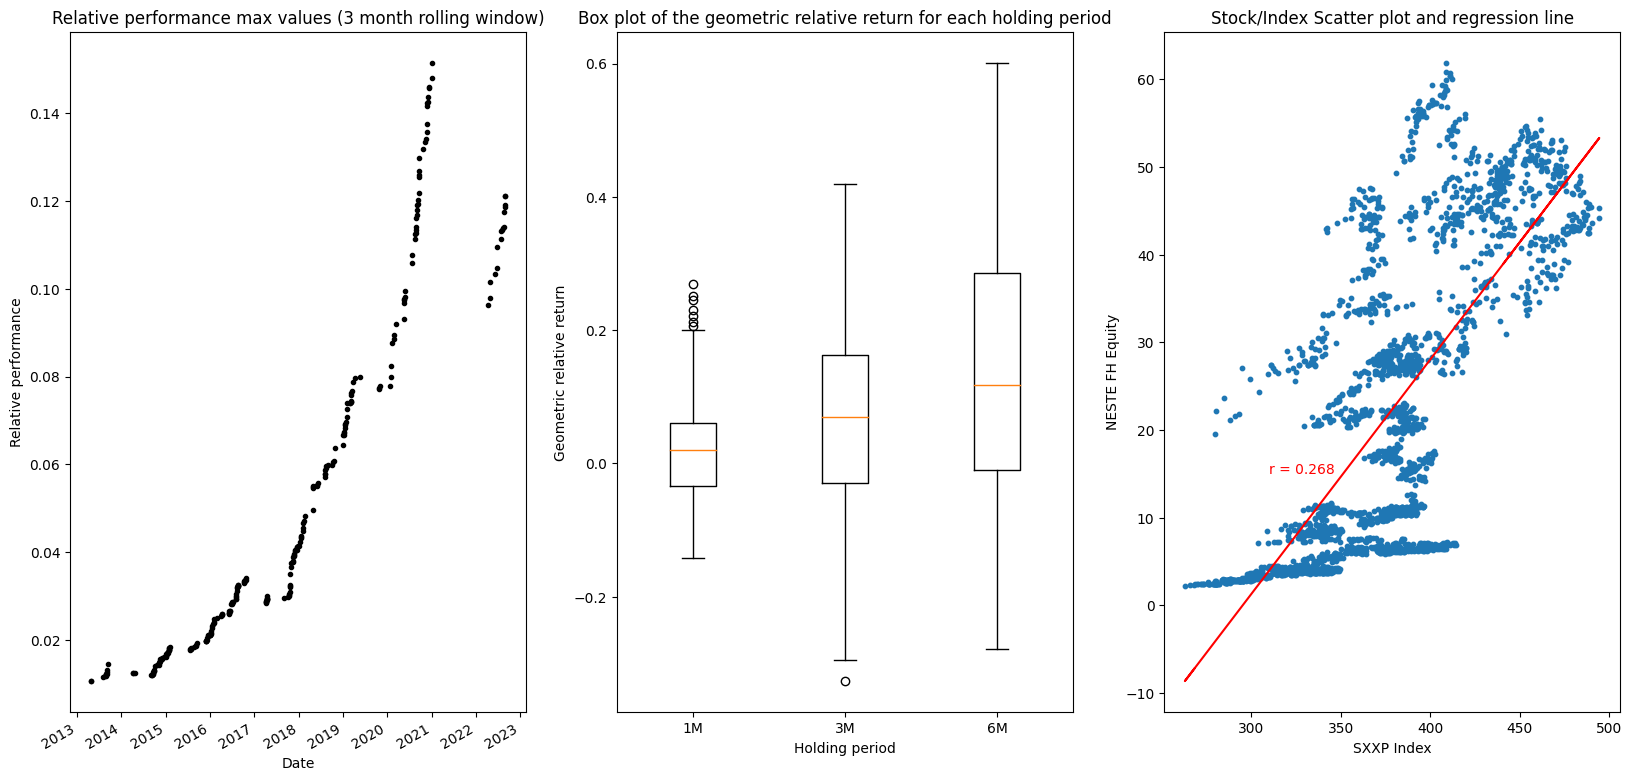

In [26]:
s= pd.Series([a[0] for a in forward_looking_relative_performance['1M']], index=[a[2] for a in forward_looking_relative_performance['1M']])
pyplot.figure(figsize=(20,10))
ax = pyplot.subplot(131)
ax.set_title('Relative performance max values (3 month rolling window)')
ax.set_xlabel('Date')
ax.set_ylabel('Relative performance')
s.plot(style = 'k.')
geometric_rr = []
label_keys = forward_looking_relative_performance.keys()
for key in label_keys:
    geometric_rr.append([(a[1]-a[0])/a[0] for a in forward_looking_relative_performance[key]])
ax = pyplot.subplot(132)
ax.set_title('Box plot of the geometric relative return for each holding period')
ax.set_xlabel('Holding period')
ax.set_ylabel('Geometric relative return')
pyplot.boxplot(geometric_rr, labels=label_keys, showfliers=True)
ax = pyplot.subplot(133)
ax.set_title('Stock/Index Scatter plot and regression line')
ax.set_xlabel(index_name)
ax.set_ylabel(stock_name)
pyplot.scatter(ts_df[index_name], ts_df[stock_name], s = 10)
a, b = np.polyfit(ts_df[index_name], ts_df[stock_name], 1)
ax.text(310, 15, f'r = {round(a, 3)}', color = "red")
pyplot.plot(ts_df[index_name], a*ts_df[index_name] + b, 'r-')
pyplot.show()